## Load data and perform cleaning and tabulation

In [1]:
%matplotlib inline

import pandas as pd
import seaborn as sns
import pylab
import numpy as np
import sklearn
from sklearn import linear_model
import sklearn.preprocessing as preprocessing
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from statsmodels.stats import proportion

import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier


from sklearn.metrics import balanced_accuracy_score, roc_auc_score,accuracy_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
param_alpha = 0.2
MAX_ALPHA = 0.5

# A_score_data_type
# dataType ="unmitigated" 
dataType = "threshold_opt"
# dataType ="Exponentiated_grad"

from fairlearn.reductions import ExponentiatedGradient,EqualizedOdds,DemographicParity

constraint = "equalized_odds"
const = EqualizedOdds()

# constraint = "demographic_parity"
# const = DemographicParity()



# Data Description From Website

Input variables:
## bank client data:
1 - age (numeric)<br>
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')<br>
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)<br>
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')<br>
5 - default: has credit in default? (categorical: 'no','yes','unknown')<br>
6 - housing: has housing loan? (categorical: 'no','yes','unknown')<br>
7 - loan: has personal loan? (categorical: 'no','yes','unknown')<br>
## related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')<br>
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')<br>
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')<br>
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.<br>
## other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)<br>
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)<br>
14 - previous: number of contacts performed before this campaign and for this client (numeric)<br>
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')<br>
## social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)<br>
17 - cons.price.idx: consumer price index - monthly indicator (numeric)<br>
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)<br>
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)<br>
20 - nr.employed: number of employees - quarterly indicator (numeric)<br>

In [3]:
df = pd.read_csv('bank.csv',sep=';')

In [4]:
df.shape

(4521, 17)

In [5]:
df.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

In [6]:
months = {'jan':1, 'feb':2, 'mar':3, 'apr':4, 'may':5, 'jun':6, 'jul':7, 'aug':8, 'sep':9, 'oct':10, 'nov':11, 'dec': 12}
df['month'] = df['month'].map(months)

In [7]:
df['default'] = df['default'].apply(lambda row: 1 if row == 'yes' else 0)
df['housing'] = df['housing'].apply(lambda row: 1 if row == 'yes' else 0)
df['loan'] = df['loan'].apply(lambda row: 1 if row == 'yes' else 0)
df['y'] = df['y'].apply(lambda row: 1 if row == 'yes' else 0)

In [8]:
df['pdays'] = df['pdays'].apply(lambda row: 0 if row == -1 else 1)

In [9]:

df = pd.get_dummies(df)

In [10]:

df.drop('marital_divorced', axis=1, inplace=True)
df.drop('job_unknown', axis=1, inplace=True)
df.drop('education_unknown', axis=1, inplace=True)
df.drop('contact_unknown', axis=1, inplace=True)
df.drop('poutcome_unknown', axis=1, inplace=True)

In [11]:
df.dtypes

age                    int64
default                int64
balance                int64
housing                int64
loan                   int64
day                    int64
month                  int64
duration               int64
campaign               int64
pdays                  int64
previous               int64
y                      int64
job_admin.             uint8
job_blue-collar        uint8
job_entrepreneur       uint8
job_housemaid          uint8
job_management         uint8
job_retired            uint8
job_self-employed      uint8
job_services           uint8
job_student            uint8
job_technician         uint8
job_unemployed         uint8
marital_married        uint8
marital_single         uint8
education_primary      uint8
education_secondary    uint8
education_tertiary     uint8
contact_cellular       uint8
contact_telephone      uint8
poutcome_failure       uint8
poutcome_other         uint8
poutcome_success       uint8
dtype: object

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
x, y = df.drop('y', axis=1), df['y']
x.shape, y.shape

((4521, 32), (4521,))

In [14]:
X_train, X_test, y_train, y_test= train_test_split(x,y, test_size=.2, random_state=42)

In [15]:
## extract sensitive features
# A = X_test["default"].map({1:"yes",0:"no"})
# A_str_test = X_test["default"]
# A_ = X_train["default"].map({1:"yes",0:"no"})
# A_str_train = X_train["default"]

A = X_test["age"].apply(lambda row: 1 if row <=30 else 0)
A_str_test = X_test["age"]
A_ = X_train["age"].apply(lambda row: 1 if row <=30 else 0)
A_str_train = X_train["age"]

In [16]:
# binarize age for test and train
X_train["age"] = X_train["age"].apply(lambda row: 1 if row <=30 else 0)
X_test["age"]= X_test["age"].apply(lambda row: 1 if row <=30 else 0)

In [17]:
import scipy.stats as ss

In [18]:
X_train.columns

Index(['age', 'default', 'balance', 'housing', 'loan', 'day', 'month',
       'duration', 'campaign', 'pdays', 'previous', 'job_admin.',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'marital_married',
       'marital_single', 'education_primary', 'education_secondary',
       'education_tertiary', 'contact_cellular', 'contact_telephone',
       'poutcome_failure', 'poutcome_other', 'poutcome_success'],
      dtype='object')

## LIGHTGBM Model for analysis


In [19]:
# Models
import lightgbm as lgb
from sklearn.calibration import CalibratedClassifierCV

lgb_params = {
    'objective' : 'binary',
    'metric' : 'cross_entropy', 
    'learning_rate': 0.1,
    'num_leaves' : 10,
    'max_depth' : 3
}

model = lgb.LGBMClassifier(**lgb_params)
train_data = X_train
train_labels = y_train
test_data = X_test
test_labels = y_test

In [20]:
model.fit(train_data, train_labels)
# Scores on test set
test_scores = model.predict_proba(test_data)[:, 1]
test_pred = model.predict(test_data)

In [21]:
# Train AUC
roc_auc_score(train_labels, model.predict_proba(train_data)[:, 1])
# ACCURACY
accuracy_score(test_labels, test_pred)
# Predictions (0 or 1) on test set
test_preds = (test_scores >= np.mean(train_labels)) * 1

Plot feature importance to visualize which features are most useful for prediction

In [22]:
# # LightGBM feature importance 
# lgb.plot_importance(model, figsize = (10,20), height=0.3, title="Features importance (LightGBM)", importance_type="gain", max_num_features=100) 
# plt.show()

In [23]:
# Data processing
from sklearn.model_selection import train_test_split

# Fairlearn algorithms and utils
from fairlearn.postprocessing import ThresholdOptimizer
from fairlearn.reductions import GridSearch, EqualizedOdds

# Metrics
from fairlearn.metrics import (
    MetricFrame,
    selection_rate, demographic_parity_difference, demographic_parity_ratio,
    false_positive_rate, false_negative_rate,
    false_positive_rate_difference, false_negative_rate_difference,
    equalized_odds_difference, count)


In [24]:
# Helper functions
def get_metrics_df(models_dict, y_true, group):
    metrics_dict = {
        "Overall selection rate": (
            lambda x: selection_rate(y_true, x), True),
        "Demographic parity difference": (
            lambda x: demographic_parity_difference(y_true, x, sensitive_features=group), True),
#         "Demographic parity ratio": (
#             lambda x: demographic_parity_ratio(y_true, x, sensitive_features=group), True),
#         "------": (lambda x: "", True),
#         "Overall balanced error rate": (
#             lambda x: 1-balanced_accuracy_score(y_true, x), True),
#         "Balanced error rate difference": (
#             lambda x: MetricFrame(metrics=balanced_accuracy_score, y_true=y_true, y_pred=x, sensitive_features=group).difference(method='between_groups'), True),
#         " ------": (lambda x: "", True),
        "False positive rate difference": (
            lambda x: false_positive_rate_difference(y_true, x, sensitive_features=group), True),
        "False negative rate difference": (
            lambda x: false_negative_rate_difference(y_true, x, sensitive_features=group), True),
        "Equalized odds difference": (
            lambda x: equalized_odds_difference(y_true, x, sensitive_features=group), True),
#         "  ------": (lambda x: "", True),
#         "Overall AUC": (
#             lambda x: roc_auc_score(y_true, x), False),
        "Accuracy": (
             lambda x: accuracy_score(y_true, x), True),
        "AUC difference": (
            lambda x: MetricFrame(metrics=roc_auc_score, y_true=y_true, y_pred=x, sensitive_features=group).difference(method='between_groups'), False),
    }
    df_dict = {}
    for metric_name, (metric_func, use_preds) in metrics_dict.items():
        df_dict[metric_name] = [metric_func(preds) if use_preds else metric_func(scores) 
                                for model_name, (preds, scores) in models_dict.items()]
    return pd.DataFrame.from_dict(df_dict, orient="index", columns=models_dict.keys())

In [25]:
if dataType =="unmitigated" or dataType =="threshold_opt":
    postprocess_est = ThresholdOptimizer(
        estimator = model,
        constraints = constraint,
        prefit=True)

    balanced_idx1 = train_data[train_labels==1].index
    pp_train_idx = balanced_idx1.union(train_labels[train_labels==0].sample(n=balanced_idx1.size, random_state=124).index)
    df_train_balanced = train_data.loc[pp_train_idx, :]
    Y_train_balanced = train_labels.loc[pp_train_idx]
    A_train_balanced = A_.loc[pp_train_idx]


    postprocess_est.fit(df_train_balanced, Y_train_balanced, sensitive_features=A_train_balanced)

    postprocess_preds = postprocess_est.predict(test_data, sensitive_features= A)
    
    if constraint == "equalized_odds":
        models_dict = {"EO_Unmit:allFeat": (test_preds, test_scores),
                   "EO_ThOpt:allFeat": (postprocess_preds, postprocess_preds)}
    if constraint == "demographic_parity":
        models_dict = {"DP_Unmit:allFeat": (test_preds, test_scores),
                   "DP_ThOpt:allFeat": (postprocess_preds, postprocess_preds)}

if dataType == "Exponentiated_grad":
    from fairlearn.reductions import ExponentiatedGradient,EqualizedOdds,DemographicParity
    from xgboost import XGBClassifier
    from sklearn.ensemble import RandomForestClassifier
    clf = RandomForestClassifier(n_estimators=10)
    xgc = XGBClassifier(verbosity=0)
    eg = ExponentiatedGradient(estimator= model, constraints = const ,max_iter=2)
    eg.fit(train_data,train_labels, sensitive_features=A_)
    eg_test_preds = eg.predict(test_data)
    
    if constraint == "equalized_odds":
        models_dict = {"EO_Unmit:allFeat": (test_preds, test_scores),
                  "EO_ExGrd:allFeat": (eg_test_preds,eg_test_preds)}
    if constraint == "demographic_parity":
        models_dict = {"DP_Unmit:allFeat": (test_preds, test_scores),
                  "DP_ExGrd:allFeat": (eg_test_preds,eg_test_preds)}    

table_init = get_metrics_df(models_dict, test_labels, A_str_test)

In [26]:
from ipynb.fs.full.BANK_DATA_FUNCTIONS import create_table
from ipynb.fs.full.BANK_DATA_FUNCTIONS import import_predef_funcs


valid_features = ['age', 'default', 'balance', 'housing', 'loan', 'day', 'month',
       'duration', 'campaign', 'pdays', 'previous', 'job_admin.',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'education_primary', 'education_secondary', 'education_tertiary',
       'education_unknown', 'contact_cellular', 'contact_telephone',
       'contact_unknown', 'poutcome_failure', 'poutcome_other',
       'poutcome_success', 'poutcome_unknown']
    

constraint = constraint
# table = pd.DataFrame() # already declared before for all features
table = table_init
for dr_feat in valid_features:
#     drop_val_f = valid_features
#     drop_val_f.remove(dr_feat) # drop one feature at a time from full list
    tempo = create_table(valid_features,train_data,train_labels,test_data,test_labels,
                  model,A,A_,A_str_train,A_str_test,
                  constraint,dr_feat,dataType)
#     print(tempo)
#     table = pd.concat(table,tempo)
    table = pd.concat([table, tempo], axis=1)
    
    
    

In [27]:
table 

,EO_Unmit:allFeat,EO_ThOpt:allFeat,EO_Unmit:age,EO_ThOpt:age,EO_Unmit:default,EO_ThOpt:default,EO_Unmit:balan,EO_ThOpt:balan,EO_Unmit:housing,EO_ThOpt:housing,...,EO_Unmit:cont_unknown,EO_ThOpt:cont_unknown,EO_Unmit:poutc_fail,EO_ThOpt:poutc_fail,EO_Unmit:poutc_other,EO_ThOpt:poutc_other,EO_Unmit:poutc_success,EO_ThOpt:poutc_success,EO_Unmit:poutc_unknown,EO_ThOpt:poutc_unknown
Overall selection rate,0.268508,0.049724,0.269613,0.054144,0.267403,0.062983,0.262983,0.046409,0.268508,0.048619,...,0.268508,0.056354,0.266298,0.051934,0.266298,0.054144,0.270718,0.053039,0.268508,0.056354
Demographic parity difference,0.077865,0.010477,0.095944,0.005388,0.079137,0.004790,0.093902,0.023970,0.106892,0.007602,...,0.077865,0.002844,0.070734,0.001743,0.080409,0.004287,0.084996,0.003015,0.077865,0.002844
False positive rate difference,0.049238,0.015595,0.070457,0.021260,0.050655,0.028343,0.073290,0.008513,0.083191,0.012762,...,0.049238,0.024093,0.040754,0.019844,0.049238,0.019844,0.056307,0.009943,0.049238,0.022677
False negative rate difference,0.013889,0.083333,0.013889,0.083333,0.013889,0.045833,0.004167,0.126389,0.013889,0.065278,...,0.013889,0.083333,0.013889,0.027778,0.038889,0.002778,0.026389,0.040278,0.013889,0.070833
Equalized odds difference,0.049238,0.083333,0.070457,0.083333,0.050655,0.045833,0.073290,0.126389,0.083191,0.065278,...,0.049238,0.083333,0.040754,0.027778,0.049238,0.019844,0.056307,0.040278,0.049238,0.070833
Accuracy,0.813260,0.899448,0.812155,0.895028,0.814365,0.892818,0.809945,0.907182,0.813260,0.902762,...,0.813260,0.892818,0.815470,0.895028,0.811050,0.897238,0.808840,0.893923,0.813260,0.895028
AUC difference,0.006356,0.049464,0.000384,0.052297,0.002013,0.037088,0.001603,0.067451,0.004923,0.026258,...,0.006356,0.053713,0.002932,0.023811,0.004904,0.011311,0.003910,0.015167,0.006356,0.046755


In [28]:
# table.iloc[:,np.arange(1,table.shape[1]+1,2)]

In [29]:
from ipynb.fs.full.BANK_DATA_FUNCTIONS import compute_Ascore


abbr_feat = {'age':"age", 'default':"default", 'balance':"balan", 'housing':"housing", 'loan':"loan", 'day':"day", 
             'month':"month",'duration':"duration", 'campaign':"campaign", 'pdays':"pdays", 'previous':"prev", 
             'job_admin.':"j_admin",'job_blue-collar':"j_bl_col", 'job_entrepreneur':"j_entr", 
             'job_housemaid':"j_hs_maid",'job_management':"j_manag", 'job_retired':"j_retire", 
             'job_self-employed':"j_self_emp", 'job_services':"j_serv",
       'job_student':"j_stud", 'job_technician':"j_techn", 'job_unemployed':"j_unempl", 'job_unknown':"j_unknown",
       'marital_divorced':"mar_div", 'marital_married':"mar_marr", 'marital_single':"mar_sing",
       'education_primary':"edu_pri", 'education_secondary':"edu_sec", 'education_tertiary':"edu_ter",
       'education_unknown':"edu_unknown", 'contact_cellular':"cont_cel", 'contact_telephone':"cont_tele",
       'contact_unknown':"cont_unknown", 'poutcome_failure':"poutc_fail", 'poutcome_other':"poutc_other",
       'poutcome_success':"poutc_success", 'poutcome_unknown':"poutc_unknown"}

    
flip_abbr = dict([(value, key) for key, value in abbr_feat.items()])

alpha = np.linspace(0,MAX_ALPHA,num=20)
checker = alpha[alpha>=param_alpha]
checker = checker[0]

Ascores, Ascore_df = compute_Ascore(table,alpha,constraint,dataType)
checker = Ascore_df.index[Ascore_df.index>=param_alpha]
checker = checker[0]
checker_idx = np.where(Ascore_df.index == checker)[0][0]

A_sc_dict = dict(zip(Ascore_df.columns,Ascore_df.iloc[checker_idx,:]))
info_dict = {}
info_dict[str(1)] = A_sc_dict
counter = 2;
k = 0
checker = valid_features
storage = []
flag = False
while np.any(Ascore_df.iloc[checker_idx,:] < 0):
        
    mx_feat = np.argmin(Ascore_df.iloc[checker_idx,:])
#     print(Ascore_df.columns[mx_feat])
    dummy = Ascore_df.columns[mx_feat]
    print(dummy)
    storage.append(dummy)
    
    if k == 0:
           
        dummy = dummy[9:]
        dummy = flip_abbr[dummy]
        valid_features.remove(dummy)
        
    else:


        dummy = dummy[9:]
        dummy = flip_abbr[dummy]
        valid_features.remove(dummy)
    
#   constraint = 'equalized_odds'
    # table = pd.DataFrame() # already declared before for all features
    table_new = create_table(valid_features,train_data,train_labels,test_data,test_labels,
                      model,A,A_,A_str_train,A_str_test,
                      constraint,None,dataType)
    for dr_feat in valid_features:
        tempo = create_table(valid_features,train_data,train_labels,test_data,test_labels,
                      model,A,A_,A_str_train,A_str_test,
                      constraint,dr_feat,dataType)
        
        table_new = pd.concat([table_new, tempo], axis=1)
    
    print(table_new.columns) 
    alpha = np.linspace(0,MAX_ALPHA,num=20)
    checker = alpha[alpha>=param_alpha]
    checker = checker[0]

    Ascores, Ascore_df = compute_Ascore(table_new,alpha,constraint,dataType)
    checker = Ascore_df.index[Ascore_df.index>=param_alpha]
#     checker = checker[0]
#     checker_idx = np.where(Ascore_df.index == checker)[0][0]

    info_dict[str(counter)] = dict(zip(Ascore_df.columns,Ascore_df.iloc[checker_idx,:]))
    counter = counter+1
    k = k+1
    
#     print(table_new.iloc[5,np.arange(0,table_new.shape[1]-1,2)])
            
    

EO_ThOpt:poutc_other
Index(['EO_Unmit:allFeat', 'EO_ThOpt:allFeat', 'EO_Unmit:age', 'EO_ThOpt:age',
       'EO_Unmit:default', 'EO_ThOpt:default', 'EO_Unmit:balan',
       'EO_ThOpt:balan', 'EO_Unmit:housing', 'EO_ThOpt:housing',
       'EO_Unmit:loan', 'EO_ThOpt:loan', 'EO_Unmit:day', 'EO_ThOpt:day',
       'EO_Unmit:month', 'EO_ThOpt:month', 'EO_Unmit:duration',
       'EO_ThOpt:duration', 'EO_Unmit:campaign', 'EO_ThOpt:campaign',
       'EO_Unmit:pdays', 'EO_ThOpt:pdays', 'EO_Unmit:prev', 'EO_ThOpt:prev',
       'EO_Unmit:j_admin', 'EO_ThOpt:j_admin', 'EO_Unmit:j_bl_col',
       'EO_ThOpt:j_bl_col', 'EO_Unmit:j_entr', 'EO_ThOpt:j_entr',
       'EO_Unmit:j_hs_maid', 'EO_ThOpt:j_hs_maid', 'EO_Unmit:j_manag',
       'EO_ThOpt:j_manag', 'EO_Unmit:j_retire', 'EO_ThOpt:j_retire',
       'EO_Unmit:j_self_emp', 'EO_ThOpt:j_self_emp', 'EO_Unmit:j_serv',
       'EO_ThOpt:j_serv', 'EO_Unmit:j_stud', 'EO_ThOpt:j_stud',
       'EO_Unmit:j_techn', 'EO_ThOpt:j_techn', 'EO_Unmit:j_unempl',
       '

In [30]:
import pprint as pp
pp.pprint(info_dict)

{'1': {'EO_ThOpt:age': 0.0038794775636880607,
       'EO_ThOpt:balan': 0.10198284408810727,
       'EO_ThOpt:campaign': -0.14935779338272967,
       'EO_ThOpt:cont_cel': -0.09764645027802914,
       'EO_ThOpt:cont_tele': 0.0048493469546101,
       'EO_ThOpt:cont_unknown': 0.00581921634553214,
       'EO_ThOpt:day': -0.02769946980473302,
       'EO_ThOpt:default': -0.08891762575973097,
       'EO_ThOpt:duration': 0.09921548342600978,
       'EO_ThOpt:edu_pri': 0.0,
       'EO_ThOpt:edu_sec': -0.024789861631966902,
       'EO_ThOpt:edu_ter': 0.0038794775636880607,
       'EO_ThOpt:edu_unknown': 0.002909608172766119,
       'EO_ThOpt:housing': -0.048523643260485305,
       'EO_ThOpt:j_admin': 0.002909608172766119,
       'EO_ThOpt:j_bl_col': -0.024789861631966902,
       'EO_ThOpt:j_entr': -0.06024828656407604,
       'EO_ThOpt:j_hs_maid': 0.002909608172766119,
       'EO_ThOpt:j_manag': -0.09376697271434108,
       'EO_ThOpt:j_retire': 0.010155610155610277,
       'EO_ThOpt:j_self_emp': 

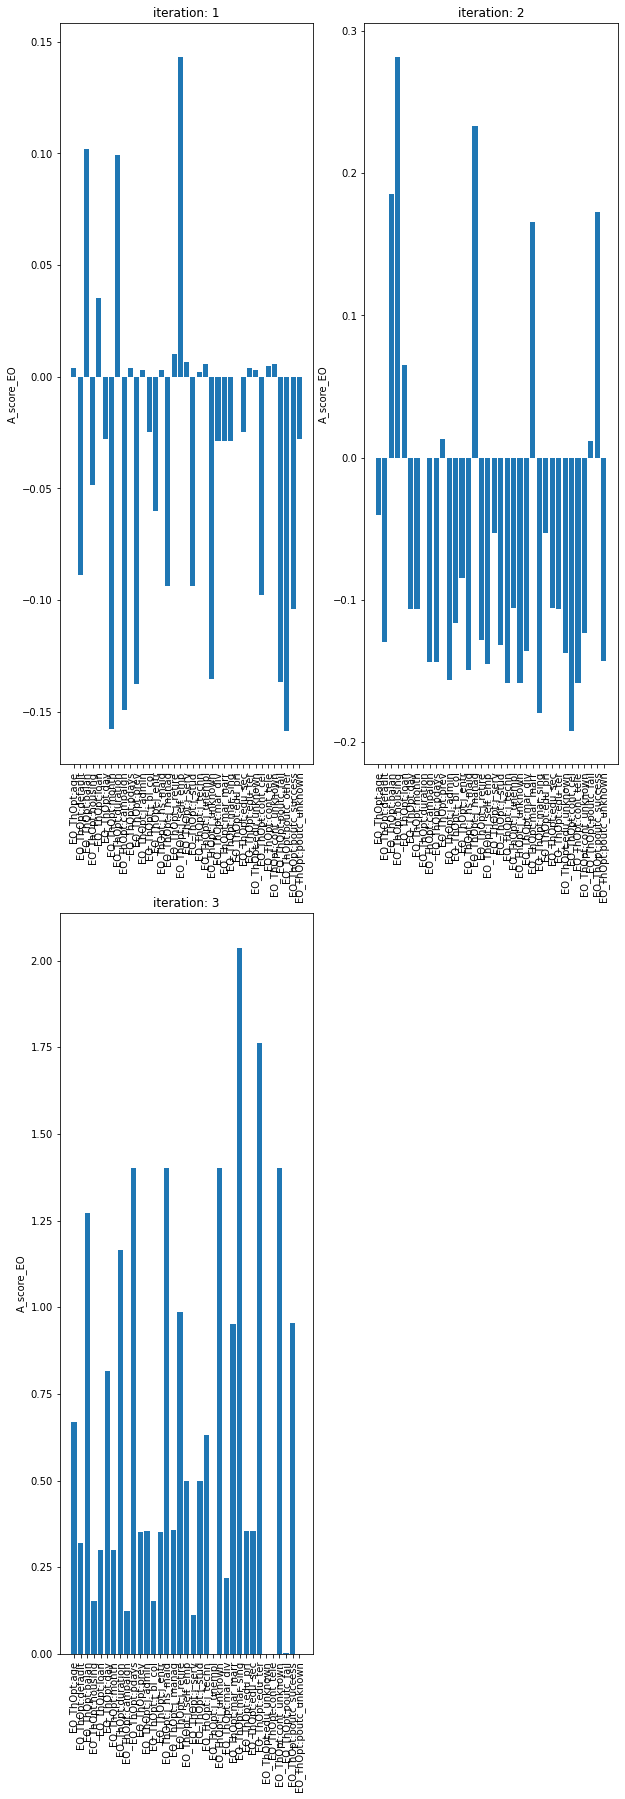

In [31]:
outer_key = info_dict.keys()
outer_val = list(info_dict.values())

plt.figure(figsize=(10,30))
for i in range(0,len(outer_val)):
    inner_keys = outer_val[i].keys()
    inner_vals = outer_val[i].values()
    plt.subplot(round(len(outer_val)/2),2,i+1)
    plt.title('iteration: '+str(i+1))
    plt.ylabel('A_score_EO')
    plt.bar(inner_keys, inner_vals)
    plt.xticks(rotation = 90);

In [32]:
print("******************************")
# dataType ="unmitigated" 
# dataType ="threshold_opt"
# dataType ="Exponentiated_grad" 
if dataType == "unmitigated":
    print("AUC vals (Unmitigated data in Ascore framework)")
    print()
    print(table_new.iloc[5,np.arange(0,table_new.shape[1]-1,2)])
if dataType == "threshold_opt":
    print("AUC vals (Threshold Opt data in framework)")
    print()
    print(table_new.iloc[5,np.arange(1,table_new.shape[1]+1,2)])
if dataType == "Exponentiated_grad":
    print("AUC vals (Exponentiated Grd data in framework)")
    print()
    print(table_new.iloc[5,np.arange(1,table_new.shape[1]+1,2)])
print("******************************")

******************************
AUC vals (Threshold Opt data in framework)

EO_ThOpt:allFeat          0.907182
EO_ThOpt:age              0.904972
EO_ThOpt:default          0.902762
EO_ThOpt:balan            0.898343
EO_ThOpt:housing          0.901657
EO_ThOpt:loan             0.898343
EO_ThOpt:day              0.896133
EO_ThOpt:month            0.896133
EO_ThOpt:duration         0.899448
EO_ThOpt:campaign         0.895028
EO_ThOpt:pdays            0.909392
EO_ThOpt:prev             0.904972
EO_ThOpt:j_admin          0.903867
EO_ThOpt:j_bl_col         0.902762
EO_ThOpt:j_entr           0.904972
EO_ThOpt:j_hs_maid        0.907182
EO_ThOpt:j_manag          0.900552
EO_ThOpt:j_retire         0.903867
EO_ThOpt:j_self_emp       0.898343
EO_ThOpt:j_serv           0.908287
EO_ThOpt:j_stud           0.898343
EO_ThOpt:j_techn          0.908287
EO_ThOpt:j_unempl         0.907182
EO_ThOpt:j_unknown        0.909392
EO_ThOpt:mar_div          0.904972
EO_ThOpt:mar_marr         0.900552
EO_ThOpt:mar_si

In [33]:
print("******************************")
# dataType ="unmitigated" 
# dataType ="threshold_opt"
# dataType ="Exponentiated_grad" 

if constraint == "equalized_odds":
    if dataType == "unmitigated" :
        print("Eq. Odds vals (Unmitigated data in Ascore framework)")
        print()
        print(table_new.iloc[4,np.arange(0,table_new.shape[1]-1,2)])
    if dataType == "threshold_opt":
        print("Eq. Odds vals (Threshold Opt data in framework)")
        print()
        print(table_new.iloc[4,np.arange(1,table_new.shape[1]+1,2)])
    if dataType == "Exponentiated_grad" :
        print("Eq. Odds vals (Exponentiated Grd data in framework)")
        print()
        print(table_new.iloc[4,np.arange(1,table_new.shape[1]+1,2)])
    print("******************************")
    
if constraint == "demographic_parity":
    if dataType == "unmitigated" :
        print("DP vals (Unmitigated data in Ascore framework)")
        print()
        print(table_new.iloc[1,np.arange(0,table_new.shape[1]-1,2)])
    if dataType == "threshold_opt":
        print("DP vals (Threshold Opt data in framework)")
        print()
        print(table_new.iloc[1,np.arange(1,table_new.shape[1]+1,2)])
    if dataType == "Exponentiated_grad" :
        print("DP vals (Exponentiated Grd data in framework)")
        print()
        print(table_new.iloc[1,np.arange(1,table_new.shape[1]+1,2)])
    print("******************************") 


******************************
Eq. Odds vals (Threshold Opt data in framework)

EO_ThOpt:allFeat          0.008333
EO_ThOpt:age              0.034722
EO_ThOpt:default          0.020833
EO_ThOpt:balan            0.058333
EO_ThOpt:housing          0.014178
EO_ThOpt:loan             0.019844
EO_ThOpt:day              0.040278
EO_ThOpt:month            0.019844
EO_ThOpt:duration         0.054167
EO_ThOpt:campaign         0.012776
EO_ThOpt:pdays            0.063889
EO_ThOpt:prev             0.022222
EO_ThOpt:j_admin          0.022222
EO_ThOpt:j_bl_col         0.014178
EO_ThOpt:j_entr           0.022222
EO_ThOpt:j_hs_maid        0.063889
EO_ThOpt:j_manag          0.022222
EO_ThOpt:j_retire         0.047222
EO_ThOpt:j_self_emp       0.027778
EO_ThOpt:j_serv           0.012762
EO_ThOpt:j_stud           0.027778
EO_ThOpt:j_techn          0.033333
EO_ThOpt:j_unempl         0.008333
EO_ThOpt:j_unknown        0.063889
EO_ThOpt:mar_div          0.016941
EO_ThOpt:mar_marr         0.045833
EO_ThOpt:m

In [34]:
outer_val = list(info_dict.values())
print(outer_val[0].keys())

dict_keys(['EO_ThOpt:age', 'EO_ThOpt:default', 'EO_ThOpt:balan', 'EO_ThOpt:housing', 'EO_ThOpt:loan', 'EO_ThOpt:day', 'EO_ThOpt:month', 'EO_ThOpt:duration', 'EO_ThOpt:campaign', 'EO_ThOpt:pdays', 'EO_ThOpt:prev', 'EO_ThOpt:j_admin', 'EO_ThOpt:j_bl_col', 'EO_ThOpt:j_entr', 'EO_ThOpt:j_hs_maid', 'EO_ThOpt:j_manag', 'EO_ThOpt:j_retire', 'EO_ThOpt:j_self_emp', 'EO_ThOpt:j_serv', 'EO_ThOpt:j_stud', 'EO_ThOpt:j_techn', 'EO_ThOpt:j_unempl', 'EO_ThOpt:j_unknown', 'EO_ThOpt:mar_div', 'EO_ThOpt:mar_marr', 'EO_ThOpt:mar_sing', 'EO_ThOpt:edu_pri', 'EO_ThOpt:edu_sec', 'EO_ThOpt:edu_ter', 'EO_ThOpt:edu_unknown', 'EO_ThOpt:cont_cel', 'EO_ThOpt:cont_tele', 'EO_ThOpt:cont_unknown', 'EO_ThOpt:poutc_fail', 'EO_ThOpt:poutc_other', 'EO_ThOpt:poutc_success', 'EO_ThOpt:poutc_unknown'])


### trying random things

In [35]:
Ascore_df.index
checker = Ascore_df.index[Ascore_df.index>=0.2]
checker = checker[0]
checker_idx = np.where(Ascore_df.index == checker)[0][0]

In [36]:
dummy = "EO_Unmit:Age"

In [37]:
dummy[0:2]+"_ThrOpt:"+dummy[9:]

'EO_ThrOpt:Age'

In [38]:
checker = valid_features

In [39]:
np.all(checker == valid_features)

True